# Description

This notebook runs some pre-analyses using DBSCAN to explore the best set of parameters (`min_samples` and `eps`) to cluster `umap` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

4

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=4
env: OPEN_BLAS_NUM_THREADS=4
env: NUMEXPR_NUM_THREADS=4
env: OMP_NUM_THREADS=4


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
np.random.seed(0)

In [6]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: umap

In [7]:
INPUT_SUBSET = "umap"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3752, 50)

In [13]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,9.587280,8.050184,9.340894,8.884522,4.562011,9.261327,9.078164,8.009141,9.288872,9.827831,...,9.753575,0.440851,-0.077164,-0.184829,9.345852,0.622542,-0.051136,4.266558,8.047482,-0.317385
100002_raw-Energy,9.910512,8.372274,9.605316,9.808598,4.641970,9.360196,8.848985,7.768594,9.231921,9.328465,...,9.647689,0.581584,0.547930,0.600128,8.976416,1.249645,0.234843,4.636343,7.173085,0.137119
100003_raw-Protein,9.923088,8.380640,9.609899,9.836457,4.647365,9.366775,8.835996,7.767549,9.230281,9.314386,...,9.642637,0.580362,0.565898,0.621073,8.967297,1.271435,0.243960,4.648671,7.149967,0.148192
100004_raw-Fat,9.898531,8.375697,9.600443,9.785713,4.639249,9.360721,8.886237,7.783376,9.237095,9.345434,...,9.648270,0.573073,0.521042,0.576926,8.979161,1.227988,0.231848,4.622777,7.205517,0.147385
100005_raw-Carbohydrate,9.895807,8.376662,9.605841,9.791338,4.636903,9.352356,8.867312,7.774787,9.233479,9.344456,...,9.652949,0.575161,0.529565,0.579919,8.988125,1.231771,0.226778,4.624360,7.194818,0.123104


## Tests different k values (k-NN)

In [14]:
k_values = np.arange(2, 125 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [15]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [16]:
eps_range_per_k = {
    k: (0.23, 0.80)
    if k < 5
    else (0.30, 0.80)
    if k < 10
    else (0.40, 2.50)
    if k < 20
    else (0.40, 7.00)
    if k < 50
    else (0.50, 10.00)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

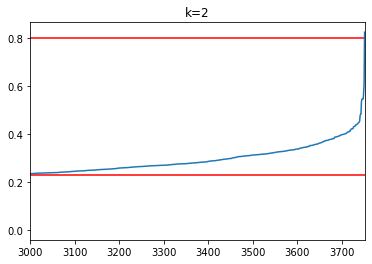

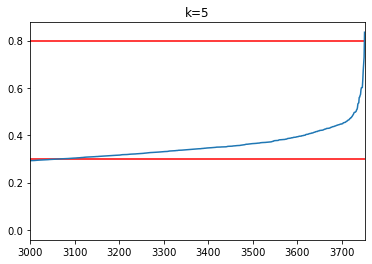

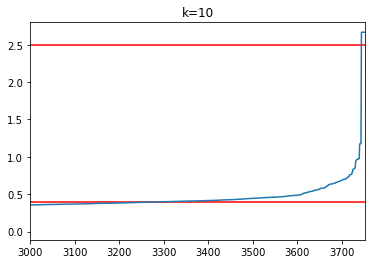

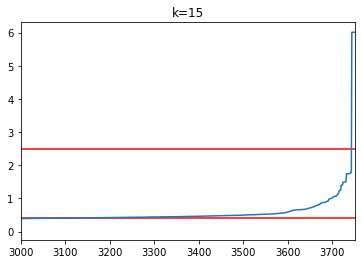

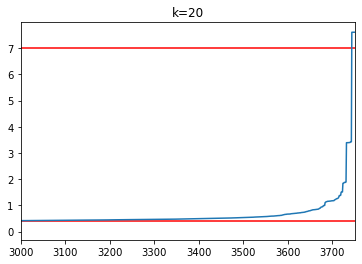

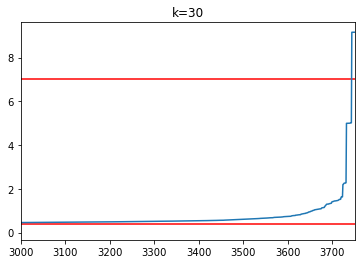

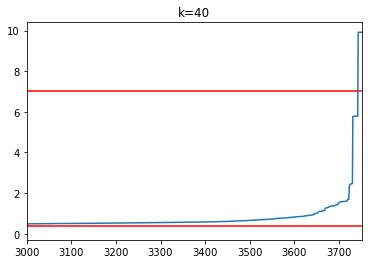

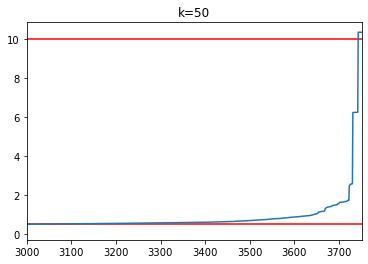

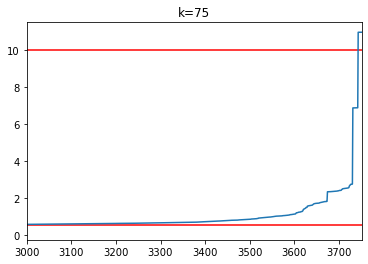

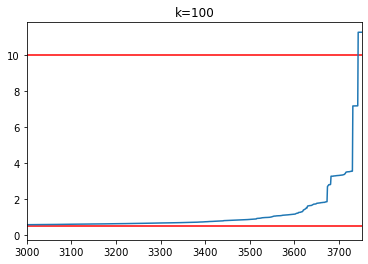

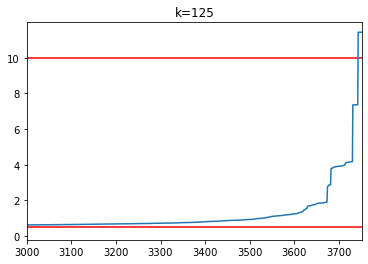

In [17]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

# Extended test

## Generate clusterers

In [18]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values_to_explore
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k_to_explore
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125),
 'EPS_RANGE_PER_K': {2: (0.23, 0.8),
  5: (0.3, 0.8),
  10: (0.4, 2.5),
  15: (0.4, 2.5),
  20: (0.4, 7.0),
  30: (0.4, 7.0),
  40: (0.4, 7.0),
  50: (0.5, 10.0),
  75: (0.5, 10.0),
  100: (0.5, 10.0),
  125: (0.5, 10.0)},
 'EPS_STEP': 33,
 'METRIC': 'euclidean'}

In [19]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [20]:
display(len(CLUSTERERS))

363

In [21]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=0.23, metric='precomputed', min_samples=2, n_jobs=4))

('DBSCAN #1',
 DBSCAN(eps=0.24781250000000002, metric='precomputed', min_samples=2, n_jobs=4))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

## Generate ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [24]:
data_dist.shape

(3752, 3752)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14077504.0
mean      3.086747407913208
std      1.5393855571746826
min                     0.0
25%        2.05721515417099
50%       3.083280563354492
75%      3.9437204003334045
max      15.400805473327637
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 363/363 [00:51<00:00,  7.07it/s]


In [27]:
ensemble.shape

(209, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.23, 'leaf_size'...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",317
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.247812500000000...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",301
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.265625, 'leaf_s...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",272
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.2834375, 'leaf_...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",257
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.30125, 'leaf_si...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",226


In [30]:
_tmp = ensemble["n_clusters"].value_counts()
display(_tmp)
assert _tmp.index[0] == 2
assert _tmp.loc[2] == 95

2      95
3      18
4      15
17      8
16      7
6       7
22      6
5       4
21      4
7       3
31      3
37      2
23      2
32      2
33      2
36      2
26      2
40      2
24      2
20      1
18      1
272     1
10      1
45      1
226     1
30      1
25      1
27      1
29      1
189     1
301     1
47      1
54      1
60      1
317     1
64      1
76      1
93      1
110     1
125     1
154     1
257     1
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    209.000000
mean      19.114833
std       46.793390
min        2.000000
25%        2.000000
50%        3.000000
75%       17.000000
max      317.000000
Name: n_clusters, dtype: float64

In [32]:
# number of noisy points
_tmp = ensemble.copy()
_tmp = _tmp.assign(n_noisy=ensemble["partition"].apply(lambda x: np.isnan(x).sum()))

In [34]:
_tmp_stats = _tmp["n_noisy"].describe()
display(_tmp_stats)
assert _tmp_stats["min"] >= 1
assert _tmp_stats["max"] < 2105
assert 110 < _tmp_stats["mean"] < 120

count     209.000000
mean      114.100478
std       230.839239
min         1.000000
25%        20.000000
50%        34.000000
75%        93.000000
max      2104.000000
Name: n_noisy, dtype: float64

## Testing

In [35]:
assert ensemble_stats["min"] > 1

In [36]:
assert not ensemble["n_clusters"].isna().any()

In [37]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

## Add clustering quality measures

In [38]:
def _remove_nans(data, part):
    not_nan_idx = ~np.isnan(part)
    return data.iloc[not_nan_idx], part[not_nan_idx]


def _apply_func(func, data, part):
    no_nan_data, no_nan_part = _remove_nans(data, part)
    return func(no_nan_data, no_nan_part)

In [39]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: _apply_func(silhouette_score, data, x)
    ),
    ch_score=ensemble["partition"].apply(
        lambda x: _apply_func(calinski_harabasz_score, data, x)
    ),
    db_score=ensemble["partition"].apply(
        lambda x: _apply_func(davies_bouldin_score, data, x)
    ),
)

In [40]:
ensemble.shape

(209, 6)

In [41]:
ensemble.head()

,clusterer_params,partition,n_clusters,si_score,ch_score,db_score
clusterer_id,,,,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.23, 'leaf_size'...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",317,-0.264103,15.603481,1.063393
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.247812500000000...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",301,-0.310631,7.521820,1.219808
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.265625, 'leaf_s...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",272,-0.370136,7.085862,1.249468
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.2834375, 'leaf_...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",257,-0.397438,7.349832,1.232750
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.30125, 'leaf_si...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",226,-0.427738,7.855357,1.253311


# Cluster quality

In [42]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,si_score,ch_score,db_score
n_clusters,,,
2,0.591376,445.398871,0.360929
3,0.422144,283.448233,0.515578
4,-0.020071,273.928295,0.779726
5,-0.155168,152.557401,0.938486
6,-0.274450,122.265991,1.297242
7,-0.024478,649.842085,1.083391
10,-0.357169,76.074582,2.827169
16,-0.306313,69.567497,0.822597
17,-0.327810,65.626853,0.865484


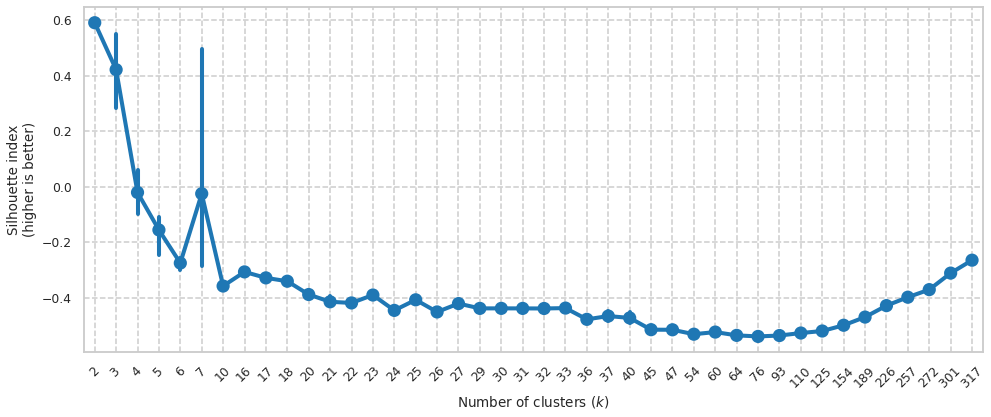

In [43]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

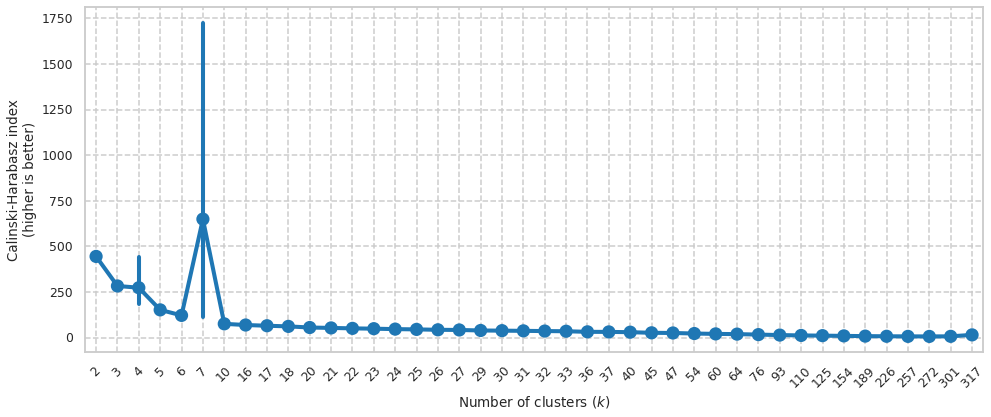

In [44]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

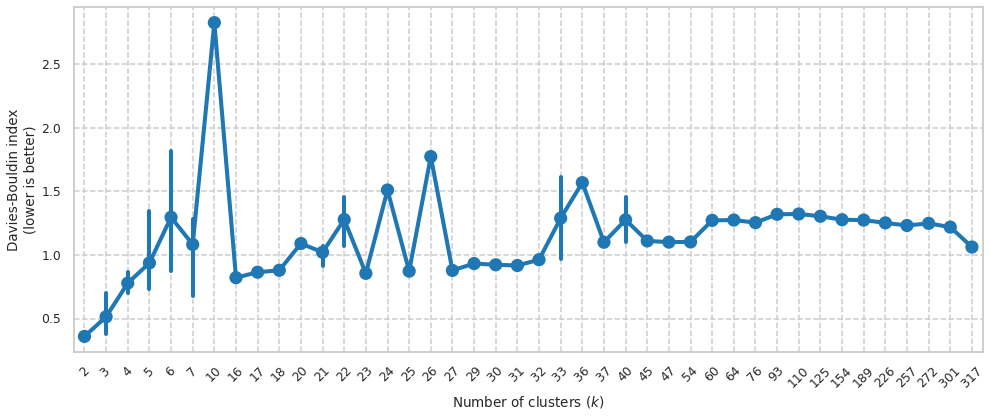

In [45]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Conclusions

The values explored above for `k_values` and `eps_range_per_k` are the one that will be used for DBSCAN in this data version.